In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
## File parameter
FOLDER_PATH = '/content/drive/MyDrive/music-retrival'
TRAIN_DATA = FOLDER_PATH+ "/data-emotion/set1/spectograms_313x149_Mel_func/"
LABEL_DATA = FOLDER_PATH + "/data-emotion/set1/mean_ratings_set1.xls"

MODEL_PATH = FOLDER_PATH + '/model/trans-mid-model/'
## DATA PARAMETER
NUM_INSTANCE = 200
TEST_SIZE = 0.2

## Model Parameter
BATCH_SIZE = 8
EPOCHS = 40
MODEL_SAVE = True

In [3]:
def load_data_label(feature_path, label_file_path):
    label_matrix = pd.read_excel(label_file_path, header=0).drop(['Number','TARGET'],axis=1)
    # Load the data from each file and concatenate into a single feature matrix
    feature_matrix = None

    for i in range(1, len(label_matrix) + 1):
        if i < 10:
          i = '00' + str(i)
        elif i < 100:
          i = '0' + str(i)

        file_path = os.path.join(feature_path, str(i) + ".mp3.npy")
        # print("Processed file " + file_path)
        data = np.load(file_path)
        data = [np.expand_dims(data, axis=-1)]
        if feature_matrix is None:
            feature_matrix = data
        else:
            feature_matrix = np.concatenate((feature_matrix, data), axis=0)
    return feature_matrix, label_matrix


In [4]:
feature_matrix, label_matrix = load_data_label(TRAIN_DATA, LABEL_DATA)

In [5]:
train_features, test_features, train_labels, test_labels = train_test_split(feature_matrix, label_matrix, test_size=TEST_SIZE, random_state=42)

In [6]:
train_labels.shape

(288, 8)

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False)

# Set the first 10 layers of the model as non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Create new input layer that accepts single-channel input
inputs = Input(shape=(313, 149, 1))
# Create a new layer that converts the single-channel input to three channels
input_layer = Conv2D(3, (3, 3), padding='same', activation='relu')(inputs)
# Pass the converted input to the pre-trained InceptionV3 model
x = base_model(input_layer)

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(2048, activation='relu')(x)
predictions = Dense(8)(x) #emotion 

model = Model(inputs=inputs, outputs=predictions)

87910968/87910968 [==============================] - 0s 0us/step


In [16]:
for layer in base_model.layers:
    layer.trainable = True

In [17]:
opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='MSE',  metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae', 'mape', 'accuracy'])

In [11]:
history = model.fit(train_features, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_features, test_labels))

Epoch 1/40
36/36 [==============================] - 121s 3s/step - loss: 5.6967 - root_mean_squared_error: 2.3868 - mae: 1.7521 - mape: 91.5553 - accuracy: 0.2118 - val_loss: 2.7729 - val_root_mean_squared_error: 1.6652 - val_mae: 1.3594 - val_mape: 66.6698 - val_accuracy: 0.1806
Epoch 2/40
36/36 [==============================] - 110s 3s/step - loss: 2.7545 - root_mean_squared_error: 1.6597 - mae: 1.3188 - mape: 64.1132 - accuracy: 0.3403 - val_loss: 4.1414 - val_root_mean_squared_error: 2.0350 - val_mae: 1.6477 - val_mape: 80.3562 - val_accuracy: 0.1528
Epoch 3/40
36/36 [==============================] - 111s 3s/step - loss: 2.7041 - root_mean_squared_error: 1.6444 - mae: 1.3092 - mape: 63.7124 - accuracy: 0.3090 - val_loss: 3.0846 - val_root_mean_squared_error: 1.7563 - val_mae: 1.3782 - val_mape: 65.2383 - val_accuracy: 0.2500
Epoch 4/40
36/36 [==============================] - 110s 3s/step - loss: 2.3007 - root_mean_squared_error: 1.5168 - mae: 1.2004 - mape: 58.8406 - accuracy: 0

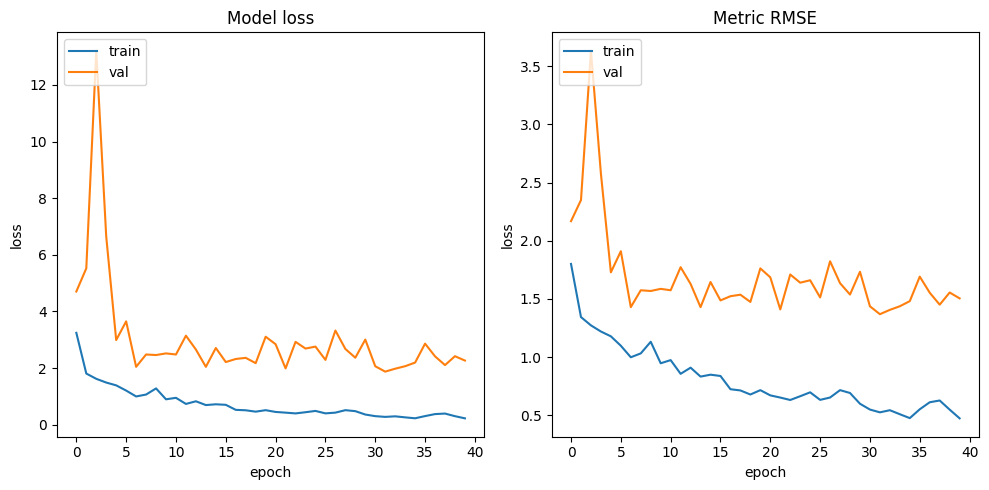

In [19]:
import matplotlib.pyplot  as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Model loss')
# ax1.ylabel('loss')
# ax1.xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')
ax1.set(xlabel='epoch', ylabel='loss')

ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.set_title('Metric RMSE')
# ax2.ylabel('loss')
# ax2.xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')
ax2.set(xlabel='epoch', ylabel='loss')

fig.tight_layout()

In [20]:
y_pred = model.predict(test_features)
y_test = test_labels

3/3 [==============================] - 11s 3s/step


In [15]:
a = model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 313, 149, 1)]     0         
                                                                 
 conv2d_94 (Conv2D)          (None, 313, 149, 3)       30        
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                             

In [21]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse = mean_squared_error(y_test, y_pred)

# Compute the R-squared value
r2 = r2_score(y_test, y_pred)

# Compute the mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation metrics
print('Mean squared error: {:.2f}'.format(mse))
print('R-squared value: {:.2f}'.format(r2))
print('Mean absolute error: {:.2f}'.format(mae))

y_pred = pd.DataFrame(y_pred)
y_pred.columns = y_test.columns.values

cor_df = dict()
print('-------------------------------')
for i in y_test.columns.values:
  corr_coef = round(np.corrcoef(y_test[i], y_pred[i])[0, 1], 2)
  if 'Emotion' not in cor_df:
    cor_df['Emotion'] = [i]
    cor_df['Correlation'] = [corr_coef]
  else:
    cor_df['Emotion'] += [i]
    cor_df['Correlation'] += [corr_coef]
cor_df = pd.DataFrame(cor_df)
cor_df

Mean squared error: 2.26
R-squared value: 0.37
Mean absolute error: 1.09
-------------------------------


,Emotion,Correlation
0,valence,0.66
1,energy,0.79
2,tension,0.71
3,anger,0.74
4,fear,0.67
5,happy,0.55
6,sad,0.59
7,tender,0.61


In [18]:
history = model.fit(train_features, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_features, test_labels))

Epoch 1/40
36/36 [==============================] - 190s 5s/step - loss: 3.2438 - root_mean_squared_error: 1.8011 - mae: 1.3779 - mape: 61.1607 - accuracy: 0.2639 - val_loss: 4.7026 - val_root_mean_squared_error: 2.1685 - val_mae: 1.6906 - val_mape: 91.4825 - val_accuracy: 0.2639
Epoch 2/40
36/36 [==============================] - 167s 5s/step - loss: 1.8064 - root_mean_squared_error: 1.3440 - mae: 1.0142 - mape: 45.8928 - accuracy: 0.3299 - val_loss: 5.5230 - val_root_mean_squared_error: 2.3501 - val_mae: 1.8557 - val_mape: 95.9554 - val_accuracy: 0.2639
Epoch 3/40
36/36 [==============================] - 167s 5s/step - loss: 1.6199 - root_mean_squared_error: 1.2728 - mae: 0.9478 - mape: 42.0122 - accuracy: 0.4097 - val_loss: 13.2075 - val_root_mean_squared_error: 3.6342 - val_mae: 2.5748 - val_mape: 128.3468 - val_accuracy: 0.1528
Epoch 4/40
36/36 [==============================] - 170s 5s/step - loss: 1.4882 - root_mean_squared_error: 1.2199 - mae: 0.8936 - mape: 39.9085 - accuracy: